In [111]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
import statsmodels.api as sm

In [112]:
df = pd.read_csv('stats.csv')
df['date'] = pd.to_datetime(df['date'])
df = df[df['item_description'] == 'Botella_750ml']
columns_drop = ['business', 'category', 'document', 'document_ID', 'client_name','total_sale_price', 'delivery_price',
       'gross_profit', 'total_taxes', 'total_tax_retention', 'current_balance',
       'amount_paid', 'payment_dates', 'gross_profit_percentage', 'address',
       'client_ID', 'item_ID', 'year_extracted', 'month_extracted','packaging','packaging','total_cost','item_description',
       'day_extracted']
df = df.drop(columns=columns_drop)
df['first_day_of_month'] = df['date'].dt.to_period('M').dt.to_timestamp()
df = df.groupby(['first_day_of_month']).agg({'unit_cost': 'mean', 'sold_quantity': 'sum', 'unit_price': 'mean'}).reset_index()
df.set_index('first_day_of_month', inplace=True)
df.head()

,unit_cost,sold_quantity,unit_price
first_day_of_month,,,
2020-01-01,9.54,22.0,15.875000
2020-02-01,9.54,19.0,17.340000
2020-03-01,9.54,28.0,15.900000
2020-04-01,9.54,19.0,15.883333
2020-05-01,9.54,60.0,16.895455


In [113]:
train = df.loc[:'2023-01-01']
test = df.loc['2023-02-01':]

In [114]:
model = VAR(train)
order = model.select_order(maxlags=7)
print(order.summary())


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       9.442       9.586   1.261e+04       9.485
1       8.299       8.875       4047.       8.470
2       8.355       9.363       4409.       8.655
3       8.177       9.616       3974.       8.605
4       7.697       9.568       2856.       8.253
5       6.912       9.216       1714.       7.597
6       6.166       8.902       1328.       6.980
7      3.909*      7.076*      353.2*      4.851*
-------------------------------------------------


d:\Users\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [115]:
var_model = VARMAX(train, order=(6,0), enforce_stationarity=True)
fit_model = var_model.fit(disp=False)
print(fit_model.summary())

d:\Users\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Users\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Users\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        Statespace Model Results                                        
Dep. Variable:     ['unit_cost', 'sold_quantity', 'unit_price']   No. Observations:                   34
Model:                                                   VAR(6)   Log Likelihood                -267.855
                                                    + intercept   AIC                            661.710
Date:                                          Thu, 04 Apr 2024   BIC                            757.870
Time:                                                  00:30:38   HQIC                           694.503
Sample:                                                       0                                         
                                                           - 34                                         
Covariance Type:                                            opg                                         
Ljung-Box (L1) (Q):       2.17, 1.97, 0.14   Jarque-Ber

In [128]:
n_future_steps = 24
predict = fit_model.get_prediction(start=len(train), end=len(train) + n_future_steps)
prediction = predict.predicted_mean

d:\Users\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
d:\Users\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [130]:
prediction.columns = ['unit_cost_yhat', 'sold_quantity_yhat', 'unit_price_yhat']
drop = ['unit_cost_yhat', 'unit_price_yhat']
prediction = prediction.drop(columns=drop)
start_date = '2023-01-01'
date_range = pd.date_range(start=start_date, periods=len(prediction), freq='MS', normalize=True)
prediction.index = date_range
prediction

,sold_quantity_yhat
2023-01-01,132.014514
2023-02-01,273.421012
2023-03-01,321.070094
2023-04-01,154.375246
2023-05-01,76.894985
2023-06-01,96.472762
2023-07-01,98.200032
2023-08-01,57.383597
2023-09-01,78.595761
2023-10-01,99.048280


<Axes: >

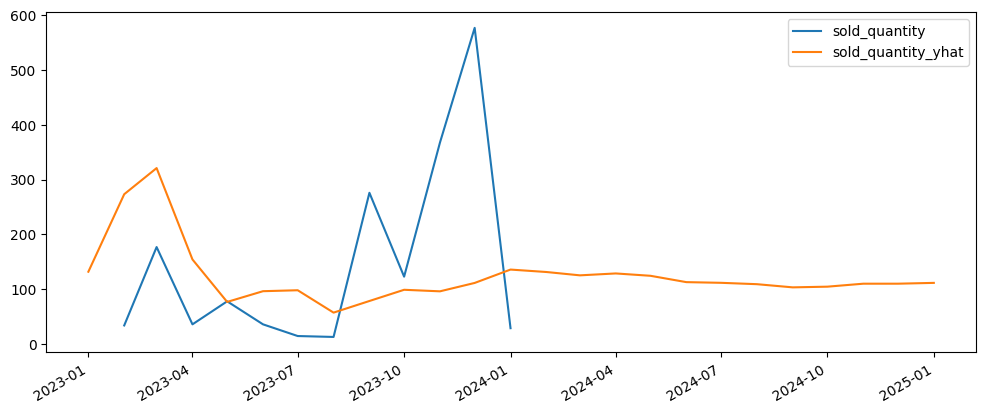

In [131]:
drop = ['unit_cost','unit_price']
test_pred = test.drop(columns=drop)

test_pred = pd.concat([test_pred, prediction])
test_pred.plot(figsize=(12,5))